In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from crepes import ConformalRegressor, ConformalPredictiveSystem

from crepes.fillings import (sigma_variance, 
                             sigma_variance_oob,
                             sigma_knn,
                             binning)

In [2]:
train = pd.read_csv('train_prep_cmaps.csv').drop('Unnamed: 0', axis=1)
cal = pd.read_csv('calib_prep_cmaps.csv').drop("Unnamed: 0", axis=1)
test = pd.read_csv('test_prep_cmap.csv').drop("Unnamed: 0", axis=1)

In [3]:
train.head()

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,125
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,125
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,125
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,125


In [4]:
test = test.drop(['engine'], axis=1)
train = train.drop(['engine'], axis=1)
cal = cal.drop(['engine'], axis=1)

In [5]:
X_train = train.drop('RUL', axis=1)
y_train = train['RUL']
X_test = test.drop('RUL', axis=1)
y_test = test['RUL']
X_cal = cal.drop('RUL', axis=1)
y_cal = cal['RUL']

print(X_train.shape)
print(X_test.shape)
print(X_cal.shape)

(16138, 17)
(2251, 17)
(2242, 17)


In [6]:
cr_std = ConformalRegressor()

In [7]:
display(cr_std)

ConformalRegressor(fitted=False)

In [8]:
learner_prop = RandomForestRegressor(n_jobs=-1, n_estimators=500) 

learner_prop.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [9]:
y_hat_cal = learner_prop.predict(X_cal)

residuals_cal = y_cal - y_hat_cal

cr_std.fit(residuals=residuals_cal)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [10]:
y_hat_test = learner_prop.predict(X_test)

intervals = cr_std.predict(y_hat=y_hat_test, confidence=0.99)

display(intervals)

array([[ 69.306, 179.63 ],
       [ 69.604, 179.928],
       [ 69.578, 179.902],
       ...,
       [-49.736,  60.588],
       [-52.106,  58.218],
       [-52.112,  58.212]])

In [74]:
def sigma_variance(X, learner, beta=1.0):
    if hasattr(learner, 'estimators_'):
        y_pred = np.array([tree.predict(X) for tree in learner.estimators_])
        return np.var(y_pred, axis=0) + beta
    else:
        return np.var(learner.predict(X)) + beta


In [75]:
intervals_std = cr_std.predict(y_hat=y_hat_test, y_min=0, y_max=1)

display(intervals_std)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [76]:
sigmas_cal_knn = sigma_knn(X=X_cal, residuals=residuals_cal)

cr_norm_knn = ConformalRegressor()

cr_norm_knn.fit(residuals=residuals_cal, sigmas=sigmas_cal_knn)

display(cr_norm_knn)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [13]:
sigmas_test_knn = sigma_knn(X=X_cal, residuals=residuals_cal, X_test=X_test)

intervals_norm_knn = cr_norm_knn.predict(y_hat=y_hat_test, 
                                         sigmas=sigmas_test_knn,
                                         y_min=0, y_max=1)

display(intervals_norm_knn)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [0., 1.],
       [0., 1.]])

In [77]:
sigmas_cal_var = sigma_variance(X=X_cal, learner=learner_prop)


cr_norm_var = ConformalRegressor()

cr_norm_var.fit(residuals=residuals_cal, sigmas=sigmas_cal_var)

display(cr_norm_var)

C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Decision

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [78]:
sigmas_test_var = sigma_variance(X=X_test, learner=learner_prop)



intervals_norm_var = cr_norm_var.predict(y_hat=y_hat_test, 
                                         sigmas=sigmas_test_var, 
                                         y_min=0, y_max=1)

display(intervals_norm_var)

C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Decision

array([[1.       , 1.       ],
       [1.       , 1.       ],
       [1.       , 1.       ],
       ...,
       [1.       , 1.       ],
       [0.8970031, 1.       ],
       [1.       , 1.       ]])

In [79]:
bins_cal, bin_thresholds = binning(values=sigmas_cal_knn, bins=20)

cr_mond = ConformalRegressor()

cr_mond.fit(residuals=residuals_cal, bins=bins_cal)

display(cr_mond)

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

In [80]:
bins_test = binning(values=sigmas_test_knn, bins=bin_thresholds)

In [81]:
intervals_mond = cr_mond.predict(y_hat=y_hat_test, bins=bins_test, 
                                         y_min=0, y_max=1)

display(intervals_mond)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [82]:
learner_full = RandomForestRegressor(n_jobs=-1, n_estimators=500, 
                                     oob_score=True)

learner_full.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

In [83]:
oob_predictions = learner_full.oob_prediction_

residuals_oob = y_train - oob_predictions

In [84]:
cr_std_oob = ConformalRegressor()

cr_std_oob.fit(residuals=residuals_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [85]:
y_hat_full = learner_full.predict(X_test)

intervals_std_oob = cr_std_oob.predict(y_hat=y_hat_full, y_min=0, y_max=1)

display(intervals_std_oob)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [86]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree(X_train, y_train, X_test):
  dt = DecisionTreeRegressor(max_depth=5)
  model = dt.fit(X_train, y_train)
  y_pred = dt.predict(X_test)
  # rmse = mean_squared_error(y_test,y_pred,squared=False)  

  return model, y_pred

In [87]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boost(X_train, y_train, X_test):
  gb = GradientBoostingRegressor(max_depth=5)
  model = gb.fit(X_train, y_train)
  y_pred = gb.predict(X_test)
  # rmse = mean_squared_error(y_test,y_pred,squared=False)

  return model, y_pred

In [88]:
from sklearn.ensemble import RandomForestRegressor


def random_forest(X_train, y_train, X_test):
  regr = RandomForestRegressor(max_depth=2, random_state=0, n_jobs = -1)
  model = regr.fit(X_train, y_train)

  return model

In [89]:
from sklearn.svm import SVR
def svr(X_train, y_train, X_test):
  svr = SVR(kernel="rbf", C=100, gamma=0.5, epsilon=0.01).fit(X_train, y_train)
  return svr

In [90]:
def plot_with_cp(y_test, y_pred, y_pis, confidence):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x,y_pred, linewidth=1.5)
  plt.plot(x,y_test, linewidth=1.3)

  #plt.plot(x[0:100],y_pis[:,0][0:100])
  #plt.plot(x[0:100],y_pis[:,1][0:100])

  plt.fill_between(x, y_pis[:,0].flatten(), y_pis[:,1].flatten(), alpha=0.2, color='tab:green', linewidth=3)

  plt.xlabel('First 100 sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of samples with confidence of ' + confidence +'%')
  plt.legend(["prediction","true",confidence + "% confidence interval"])
  plt.grid(True)
  plt.show()

In [91]:
from crepes import ConformalRegressor, ConformalPredictiveSystem

def conformal_prediction(model, a, X_train, y_train, X_test):
    crep = ConformalRegressor()
    cr_mond = ConformalRegressor()
    cr_mond.fit(residuals=residuals_cal, bins=bins_cal)
    display(cr_mond)


    

In [92]:
def conformal_prediction_crepes(model, alpha, X_cali, y_cali, X_test):
  #Standard conformal regressors
  cr_std = ConformalRegressor()
  y_hat_cal = model.predict(X_cali)
  residuals_cal = y_cali - y_hat_cal
  cr_std.fit(residuals=residuals_cal)
  y_hat_test = model.predict(X_test)
  intervals = cr_std.predict(y_hat=y_hat_test, confidence=1-alpha)

  return y_hat_test, intervals

In [93]:
def conformal_prediction_crepes_mondrian(model, bin, X_cali, y_cali, X_test):
  #Standard conformal regressors
  cr_std = ConformalRegressor()
  y_hat_cal = model.predict(X_cali)
  residuals_cal = y_cali - y_hat_cal
  cr_std.fit(residuals=residuals_cal)
  y_hat_test = model.predict(X_test)

  #Normalized conformal regressors
  sigmas_cal_var = sigma_variance(X=X_cali, learner=model)
  cr_norm_var = ConformalRegressor()
  cr_norm_var.fit(residuals=residuals_cal, sigmas=sigmas_cal_var)
  sigmas_test_var = sigma_variance(X=X_test, learner=model)
  #Mondrian conformal regressors
  bins_cal, bin_thresholds = binning(values=sigmas_cal_var, bins=bin)
  cr_mond = ConformalRegressor()
  cr_mond.fit(residuals=residuals_cal, bins=bins_cal)
  bins_test = binning(values=sigmas_test_var, bins=bin_thresholds)
  intervals_mond = cr_mond.predict(y_hat=y_hat_test, bins=bins_test)

  return y_hat_test, intervals_mond

In [108]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

def sigma_variance(X, learner, beta=0.05):
    if not hasattr(learner, 'estimators_'):
        # If the learner does not have the estimators_ attribute, create a new model to get predictions
        base_learner = DecisionTreeRegressor()
        base_learner.fit(X, np.zeros(X.shape[0]))  # fit the model with zeros for the targets
        return np.var([base_learner.predict(X) for i in range(learner.n_estimators)],
                      axis=0) + beta
    else:
        return np.var([model.predict(X) for model in learner.estimators_],
                      axis=0) + beta



# def sigma_variance(X, learner, beta=1.0):
#     print("Using modified sigma_variance function") 
#     if hasattr(learner, 'estimators_'):
#         y_pred = np.array([tree.predict(X) for tree in learner.estimators_])
#         return np.var(y_pred, axis=0) + beta
#     else:
#         return np.var(learner.predict(X)) + beta


In [109]:
# rf_model_3 = decision_tree(X_train_3, y_train_3, X_test_3)
dt_model, y_pred = decision_tree(X_train, y_train, X_test)

In [96]:
y_pred_dt, y_pis_dt = conformal_prediction_crepes(dt_model, 0.1, X_cal, y_cal, X_test)

In [34]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_dt)

0.7102127973107601

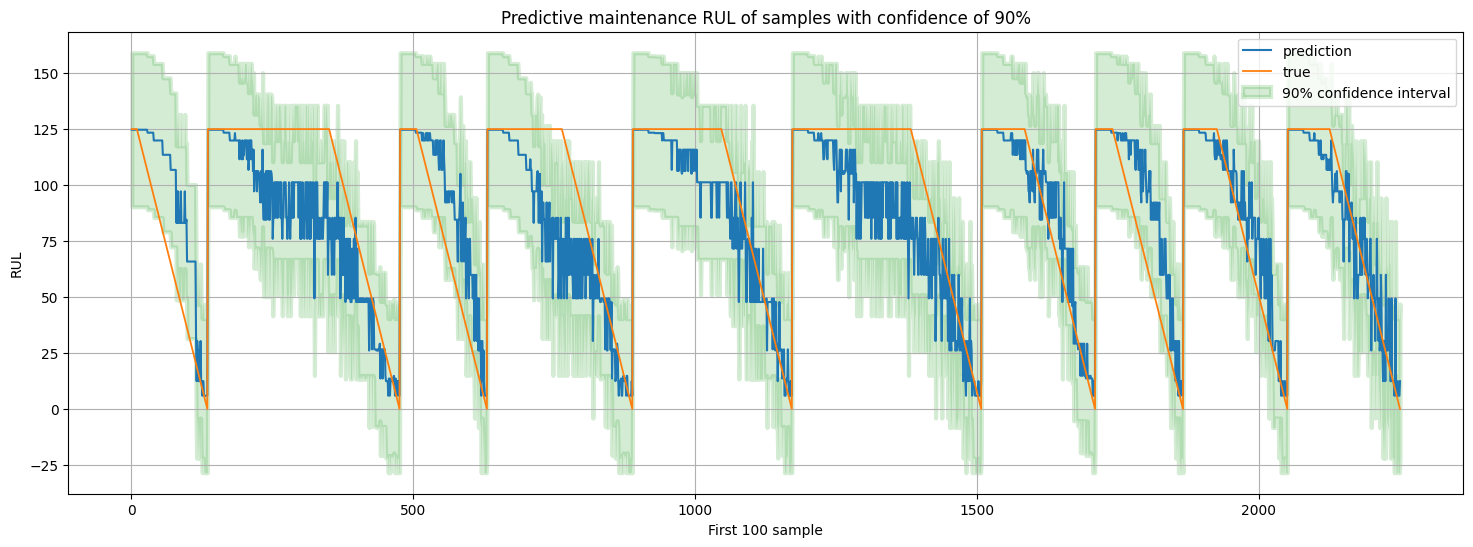

In [35]:
plot_with_cp(y_test, y_pred_dt, y_pis_dt, "90")

In [110]:
gb_model, y_pred = gradient_boost(X_train, y_train, X_test)

In [111]:
y_pred_gb, y_pis_gb = conformal_prediction_crepes(gb_model, 0.1, X_cal, y_cal, X_test)

In [62]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_gb)

0.7913149831655107

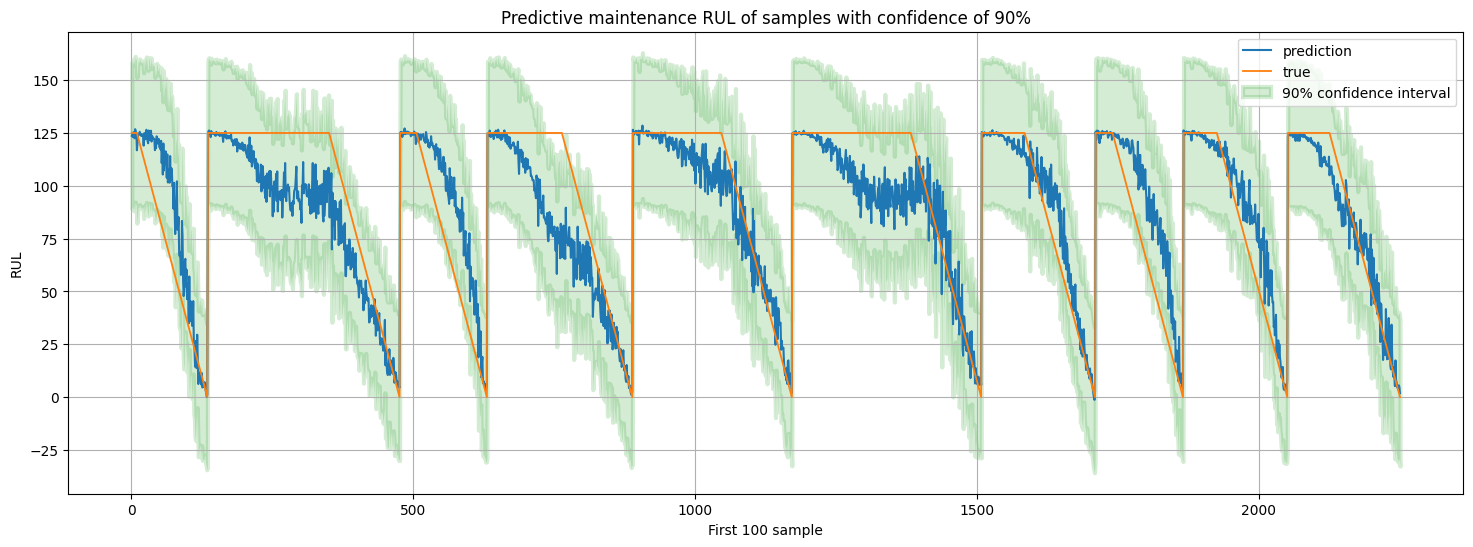

In [63]:
plot_with_cp(y_test, y_pred_gb, y_pis_gb, "90")

In [112]:
y_pred_gb_mondrian, y_pis_gb_mondrian = conformal_prediction_crepes_mondrian(gb_model, 20, X_cal, y_cal, X_test)

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [66]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_gb_mondrian)

NameError: name 'y_pred_gb_mondrian' is not defined

In [65]:
plot_with_cp(y_test, y_pred_gb_mondrian, y_pis_gb_mondrian, "90")

NameError: name 'y_pred_gb_mondrian' is not defined

# LSTM

In [54]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [55]:
df = pd.read_csv('lstm_data.csv').drop('Unnamed: 0', axis=1)
df.head()

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,125
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,125
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,125
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,125
